Initialized stellar population with FSPS.
The prior on log mass is uniform from 9.0 to 12.0
The prior on log SFR_inst is uniform from -1.0 to 2.0
The prior on redshift is uniform from 0.9 to 1.1
The prior on log metallicity/Zsolar is uniform from -1.5 to 0.5
The prior on dust (model: Calzetti) is uniform from 0.0 to 1.0
[11.54645309 -0.46331223  1.          0.457921  ]


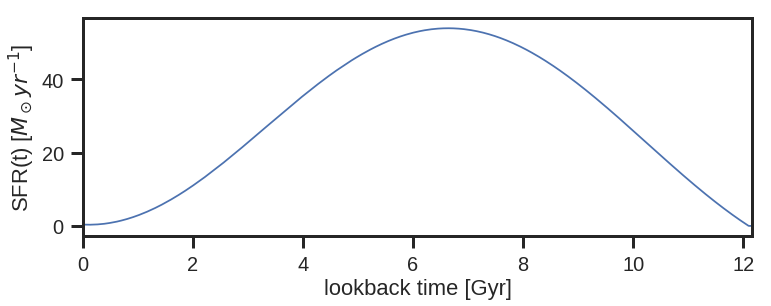

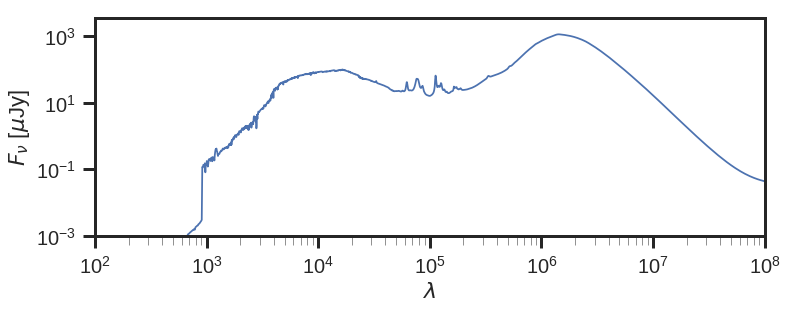

In [1]:
import matplotlib.pyplot as plt
import dense_basis as db
import numpy as np
import sys

# print priors
db.print_priors()

# sample from priors: M*, SFR, tx, Av, Z, z

rand_sfh_tuple = db.sample_sfh_tuple(random_seed = 15, Nparam = 1)
print(rand_sfh_tuple)

rand_sfh, rand_time = db.gp_sfh_sklearn(rand_sfh_tuple, zval = 0.1)

db.plot_sfh(rand_time, rand_sfh, lookback=True)

rand_sfh_tuple, rand_Z, rand_Av, rand_z = db.sample_all_params(random_seed = 15, Nparam = 1)
rand_spec, rand_lam = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_lam = True)

db.plot_spec(rand_lam, rand_spec)

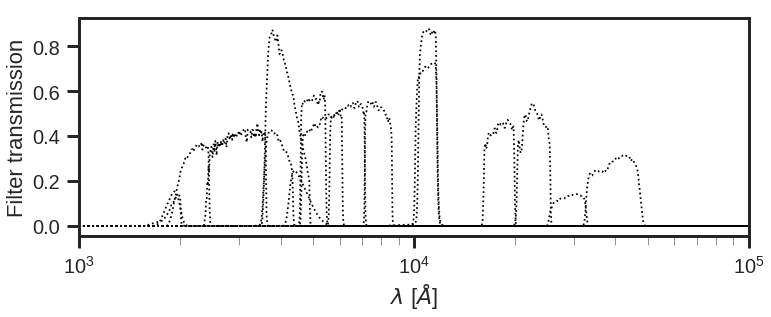

In [2]:
# now generate SED

centers_goods_s = np.array([3734,3722,4317,5918,7693,8047,9055,9851,10550,12486,15370,21605,21463,35508,44960,57245,78840])

filter_list = 'dense_basis/filters/filter_list_goodss.dat'
filcurves, lam_z, lam_z_lores = db.make_filvalkit_simple(rand_lam, rand_z, fkit_name = filter_list, )

plt.figure(figsize=(12,4))
plt.plot(rand_lam, filcurves,'k:');
plt.xscale('log'); plt.xlim(1e3,1e5)
plt.xlabel(r'$\lambda$ [$\AA$]');plt.ylabel('Filter transmission')
plt.show()

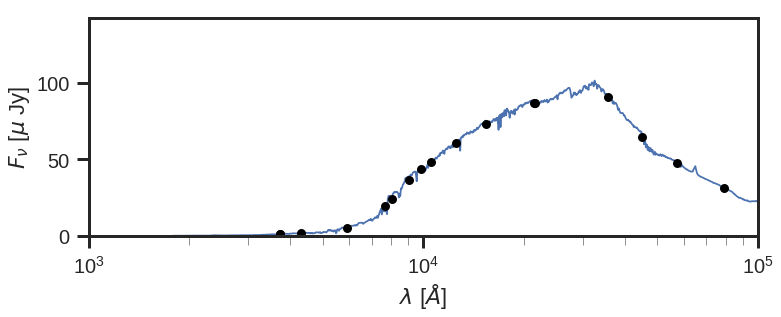

In [3]:
rand_sed = db.calc_fnu_sed_fast(rand_spec,filcurves)

plt.figure(figsize=(12,4))
plt.plot(rand_lam*(1+rand_z), rand_spec)
plt.plot(centers_goods_s, rand_sed,'ko',markersize=9)
plt.xscale('log'); plt.xlim(1e3,1e5)
plt.xlabel(r'$\lambda$ [$\AA$]');plt.ylabel(r'$F_\nu$ [$\mu$ Jy]')
plt.ylim(0,np.amax(rand_spec[rand_lam<1e5])*1.4)
plt.show()

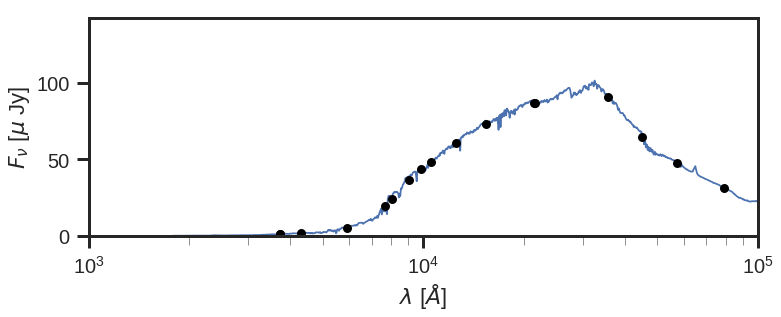

In [4]:
# try the other filter curve function as well. More useful when dealing with differing filtersets.

rand_sed = db.calc_fnu_sed(rand_spec, rand_z, rand_lam, fkit_name = filter_list)

plt.figure(figsize=(12,4))
plt.plot(rand_lam*(1+rand_z), rand_spec)
plt.plot(centers_goods_s, rand_sed,'ko',markersize=9)
plt.xscale('log'); plt.xlim(1e3,1e5)
plt.xlabel(r'$\lambda$ [$\AA$]');plt.ylabel(r'$F_\nu$ [$\mu$ Jy]')
plt.ylim(0,np.amax(rand_spec[rand_lam<1e5])*1.4)
plt.show()

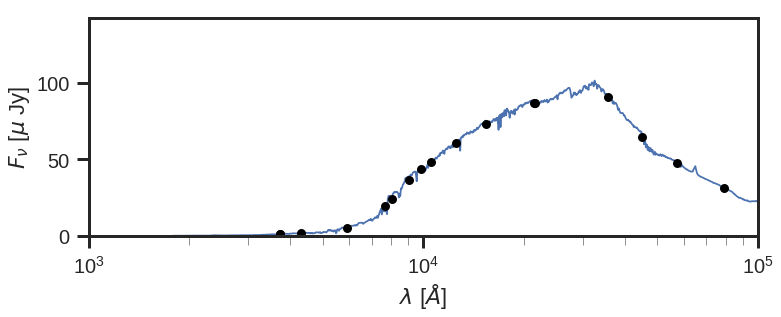

In [5]:
rand_sed = db.make_sed_fast(rand_sfh_tuple, rand_Z, rand_Av, rand_z, filcurves)

plt.figure(figsize=(12,4))
plt.plot(rand_lam*(1+rand_z), rand_spec)
plt.plot(centers_goods_s, rand_sed,'ko',markersize=9)
plt.xscale('log'); plt.xlim(1e3,1e5)
plt.xlabel(r'$\lambda$ [$\AA$]');plt.ylabel(r'$F_\nu$ [$\mu$ Jy]')
plt.ylim(0,np.amax(rand_spec[rand_lam<1e5])*1.4)
plt.show()

In [6]:
filter_list = 'dense_basis/filters/filter_list_goodss.dat'

rand_sfh_tuples, rand_Zs, rand_Avs, rand_zs, rand_seds = db.generate_pregrid(filter_list=filter_list)

100%|██████████| 10/10 [00:12<00:00,  1.01it/s]


In [7]:
rand_seds.shape

(17, 10)

In [5]:
filter_list = 'dense_basis/filters/filter_list_goodss.dat'

rand_sfh_tuples, rand_Zs, rand_Avs, rand_zs, rand_seds = db.generate_pregrid(N_pregrid= 1000, 
                                                                             filter_list=filter_list)

100%|██████████| 1000/1000 [05:42<00:00,  3.06it/s]


In [12]:
filter_list = 'dense_basis/filters/filter_list_goodss.dat'

db.generate_pregrid(N_pregrid= 10000, store = True, filter_list=filter_list)

100%|██████████| 10000/10000 [59:41<00:00,  2.53it/s] 


In [11]:
import scipy.io as sio
sio.whosmat('dense_basis/pregrids/sfh_pregrid_size_10.mat')

[('rand_sfh_tuples', (4, 10), 'double'),
 ('rand_Z', (1, 10), 'double'),
 ('rand_Av', (1, 10), 'double'),
 ('rand_z', (1, 10), 'double'),
 ('rand_seds', (17, 10), 'double')]

# begin emcee fit

In [7]:
import emcee
import corner

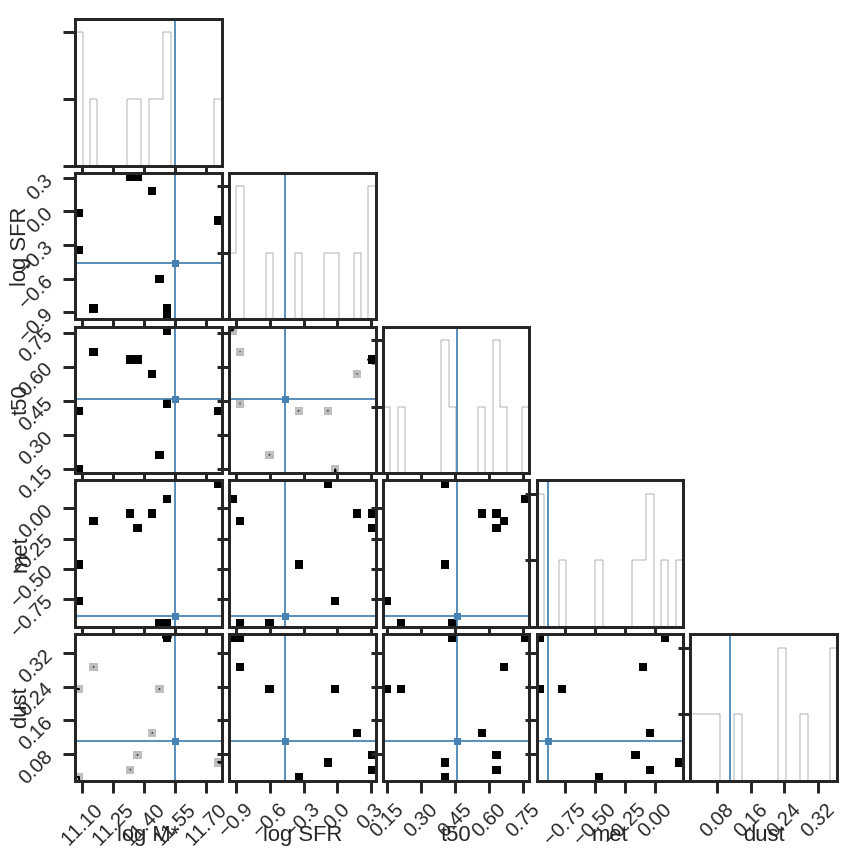

In [25]:
ndim, nwalkers, nsteps = 5, 10, 1000

# mass, sfr, t50, 
pos_min = np.array([11.0, -1.0, 0.1, -1.0, 0.0])
pos_max = np.array([12.0, 1.0, 0.9, 0.5, 0.5])

psize = pos_max - pos_min
pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

fig = corner.corner(pos, labels = ['log M*', 'log SFR', 't50', 'met', 'dust'], 
                    truths = [rand_sfh_tuple[0], rand_sfh_tuple[1], rand_sfh_tuple[3], rand_Z, rand_Av])
fig.set_size_inches(12,12)
plt.show()

In [26]:
# prior: uniform - rewrite to be conditional with multiple tx
def lnprior(theta):
    mstar, sfr, t50, Z, Av = theta
    sfh_tuple = np.array([mstar, sfr, 1.0, t50])
    if 11.0 < mstar < 12.0 and -1.0 < sfr < 1.0 and 0.1 < t50 < 1.0 and -1.0 < Z < 0.5 and 0.0 < Av < 0.5:
        return 0.0
    return -np.inf

# likelihood chi^2
def lnlike(theta, sed, z_true, filcurves):
    mstar, sfr, t50, Z, Av = theta
    sfh_tuple = np.array([mstar, sfr, 1.0, t50])
    model_sed = db.make_sed_fast(sfh_tuple, Z, Av, z_true, filcurves)
    chi2 = (sed-model_sed)**2 / (sed*0.03)**2
    return np.sum(-chi2/2)

def lnprob(theta, sed, z_true, filcurves):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, sed, z_true, filcurves)


In [27]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (rand_sed, rand_z, filcurves), threads = 4)

In [28]:
import time

time0 = time.time()
pos, prob, state = sampler.run_mcmc(pos, 10)
sampler.reset()

time1 = time.time()
print(time1-time0)

33.33990406990051


In [29]:
time0 = time.time()

width = 81
for i, result in enumerate(sampler.sample(pos, iterations = nsteps)):
    n = int((width+1)*float(i)/nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n , ' '*(width-n)))
sys.stdout.write("\n")

time1 = time.time()
print(time1-time0)

[#################################################################################]
935.7988948822021


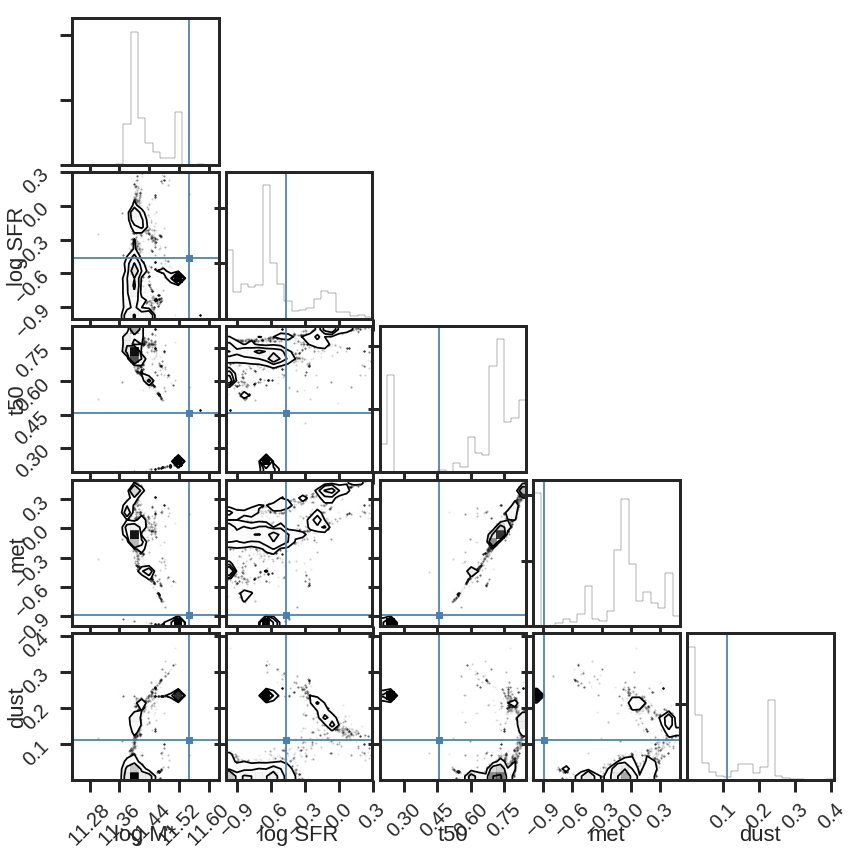

In [30]:
samples = sampler.flatchain
samples.shape

fig = corner.corner(samples, labels = ['log M*', 'log SFR', 't50', 'met', 'dust'], 
                    truths = [rand_sfh_tuple[0], rand_sfh_tuple[1], rand_sfh_tuple[3], rand_Z, rand_Av])
fig.set_size_inches(12,12)
plt.show()


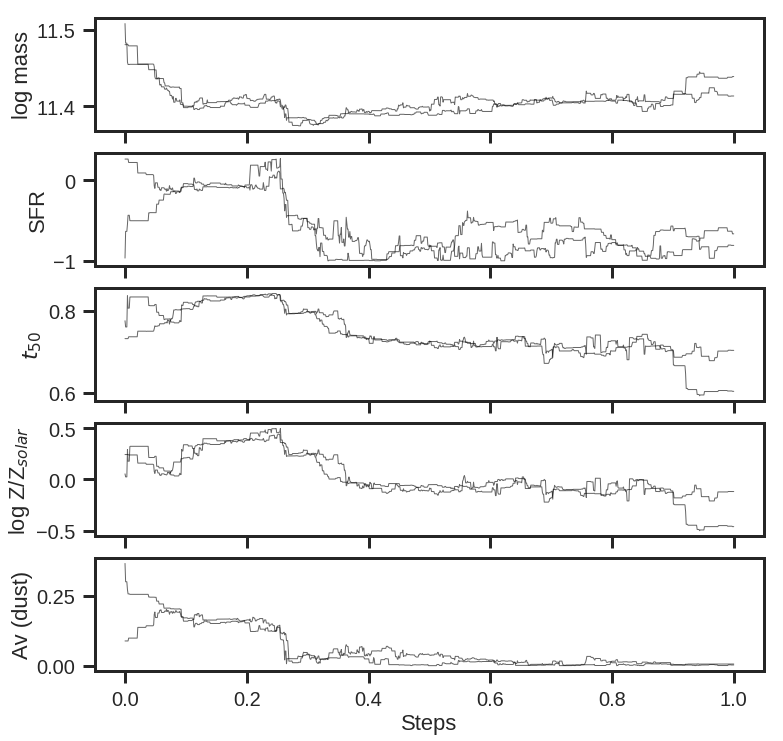

In [33]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(12, 12))
for i, [ax, param] in enumerate(zip(axes, ['log mass', r'SFR', r'$t_{50}$', r'log Z/Z$_{solar}$', 'Av (dust)'])):
    walkers = sampler.chain[:, :, i]
    for walker in walkers[::5]:
        ax.plot(np.linspace(0,1,nsteps), walker, lw=1.0, color='k', alpha=0.6)
    ax.set_ylabel(param)

#axes[ndim-1].set_yscale('log')
axes[ndim-1].set_xlabel('Steps');
plt.show()